<a href="https://colab.research.google.com/github/chongzicbo/Dive-into-Deep-Learning-tf.keras/blob/master/7.6.%20RMSProp%E7%AE%97%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##7.6. RMSProp算法
我们在“AdaGrad算法”一节中提到，因为调整学习率时分母上的变量 $s_t$ 一直在累加按元素平方的小批量随机梯度，所以目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。因此，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。为了解决这一问题，RMSProp算法对AdaGrad算法做了一点小小的修改。该算法源自Coursera上的一门课程，即“机器学习的神经网络” [1]。

###7.6.1. 算法
我们在“动量法”一节里介绍过指数加权移动平均。不同于AdaGrad算法里状态变量 $s_t$ 是截至时间步 $t$ 所有小批量随机梯度 $g_t$ 按元素平方和，RMSProp算法将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数$0 \leq \gamma < 1$，RMSProp算法在时间步 $t>0$ 计算
$$
\boldsymbol{s}_t \leftarrow \gamma \boldsymbol{s}_{t-1} + (1 - \gamma) \boldsymbol{g}_t \odot \boldsymbol{g}_t.
$$
和AdaGrad算法一样，RMSProp算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量
$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,
$$
其中 $\eta$ 是学习率， $\epsilon$是为了维持数值稳定性而添加的常数，如 $10^{-6}$ 。因为RMSProp算法的状态变量 $s_t$ 是对平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的指数加权移动平均，所以可以看作是最近$1/(1-\gamma)$个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低（或不变）。

照例，让我们先观察RMSProp算法对目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$中自变量的迭代轨迹。回忆在“AdaGrad算法”一节使用的学习率为0.4的AdaGrad算法，自变量在迭代后期的移动幅度较小。但在同样的学习率下，RMSProp算法可以更快逼近最优解。

In [0]:
%matplotlib inline
import math
import tensorflow as tf
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.data import Dataset
import time

In [0]:
tf.enable_eager_execution()

###7.6.2. 从零开始实现
接下来按照RMSProp算法中的公式实现该算法。

In [0]:
def rmsprop_2d(x1,x2,s1,s2):
  g1,g2,eps=0.2*x1,4*x2,1e-6
  s1=gamma*s1+(1-gamma)*g1**2
  s2=gamma*s2+(1-gamma)*g2**2
  x1-=eta /math.sqrt(s1+eps)*g1
  x2-=eta/math.sqrt(s2+eps)*g2
  return x1,x2,s1,s2

def f_2d(x1,x2):
  return 0.1*x1**2+2*x2**2  

In [0]:
def show_trace_2d(f,results):
  plt.plot(*zip(*results),'-o',color='#ff7f0e')
  x1,x2=np.meshgrid(np.arange(-5.5,1.0,0.1),np.arange(-3.0,1.0,0.1))
  plt.contour(x1,x2,f(x1,x2),colors='#1f77b4')
  plt.xlabel('x1')
  plt.ylabel('x2')

def train_2d(trainer):
  x1,x2,s1,s2=-5,-2,0,0
  results=[(x1,x2)]
  for i in range(20):
    x1,x2,s1,s2=trainer(x1,x2,s1,s2)
    results.append((x1,x2))
  print('epoch %d,x1 %f,x2 %f'%(i+1,x1,x2))
  return results  

epoch 20,x1 -0.010599,x2 0.000000


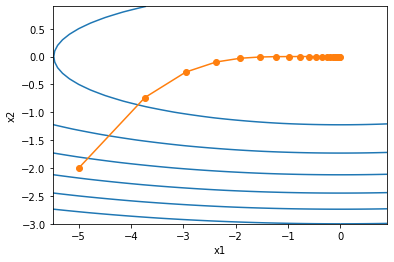

In [0]:
eta,gamma=0.4,0.9
show_trace_2d(f_2d,train_2d(rmsprop_2d))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

def get_data_ch7():
  data=np.genfromtxt('/content/drive/My Drive/data/d2l-zh-tensoflow/airfoil_self_noise.dat',delimiter='\t')
  data=(data-data.mean(axis=0))/data.std(axis=0)
  return tf.constant(data[:1500,:-1]),tf.constant(data[:1500,-1])

features,labels=get_data_ch7()  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def init_rmsprop_states():
  s_w=tf.Variable(tf.zeros(shape=(features.shape[1],1),dtype=tf.double))
  s_b=tf.Variable(tf.zeros(1,dtype=tf.double))
  return (s_w,s_b)

def rmsprop(params,states,hyperparams,loss,t):
  gamma,eps=hyperparams['gamma'],1e-6
  for p,s in zip(params,states):
    dl_dp=t.gradient(loss,p)
    s.assign(gamma*s+(1-gamma)*tf.square(dl_dp))
    p.assign_sub(hyperparams['lr']*dl_dp/tf.sqrt(s+eps))  

In [0]:
def train_ch7(trainer_fn,states,hyperparams,features,labels,batch_size=10,num_epochs=2):
  net,loss=linreg,squared_loss
  w=tf.Variable(tf.random.normal(stddev=0.01,shape=(features.shape[1],1),dtype=tf.double))
  b=tf.Variable(tf.zeros(1,dtype=tf.double))

  def eval_loss():
    return tf.reduce_mean(loss(net(features,w,b),labels)).numpy()

  ls=[eval_loss()]

  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)

  for _ in range(num_epochs):
    start=time.time()
    for batch_i,(X,y) in enumerate(data_iter):
      with tf.GradientTape(persistent=True) as t:
        t.watch([w,b])
        l=tf.reduce_mean(loss(net(X,w,b),y)) #使用平均损失

      trainer_fn([w,b],states,hyperparams,l,t) #迭代模型参数

      if(batch_i+1)*batch_size %100==0:
        ls.append(eval_loss()) #每100个样本记录下当前训练误差
  # 打印结果和作图
  print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
  set_figsize()
  plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')  

In [0]:

def use_svg_display():
  #用矢量图显示
  display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  #设置图的尺寸
  plt.rcParams['figure.figsize']=figsize
  
  
def linreg(X,w,b):
  return tf.matmul(X,w)+b 
  
def squared_loss(y_hat,y):
  return (y_hat-tf.reshape(y,shape=y_hat.shape))**2/2  

loss: 0.242277, 0.678375 sec per epoch


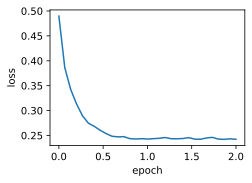

In [0]:
train_ch7(rmsprop,init_rmsprop_states(),{'lr':0.01,'gamma':0.9},features,labels)

In [0]:
class LossHistory(keras.callbacks.Callback): 
  def on_train_begin(self, logs={}): 
    self.losses = [] 
    # self.val_losses = [] 


  def on_batch_end(self, batch, logs={}): 
    self.losses.append(logs.get('loss')) 
    # self.val_losses.append(logs.get('val_loss')) 

###7.6.3. 简洁实现


In [0]:
def train_keras_ch7(trainer_name,features,labels,batch_size=10,num_epochs=2):
  net=keras.Sequential(keras.layers.Dense(1))
  loss=losses.MeanSquaredError()
  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)
  net.compile(optimizer=trainer_name,loss=loss,metrics=['mse'])
  history=net.fit_generator(data_iter,epochs=num_epochs,callbacks=[LossHistory()])
  loss_ls=history.history['loss']
  set_figsize()
  plt.plot(np.linspace(0,num_epochs,len(loss_ls)),loss_ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  return history

Epoch 1/10
30/30 [==============================] - 0s 13ms/step - loss: 2.0990 - mean_squared_error: 2.3427
Epoch 2/10
30/30 [==============================] - 0s 10ms/step - loss: 1.1065 - mean_squared_error: 1.2288
Epoch 3/10
30/30 [==============================] - 0s 11ms/step - loss: 0.6419 - mean_squared_error: 0.7091
Epoch 4/10
30/30 [==============================] - 0s 11ms/step - loss: 0.5009 - mean_squared_error: 0.5236
Epoch 5/10
30/30 [==============================] - 0s 11ms/step - loss: 0.4883 - mean_squared_error: 0.5054
Epoch 6/10
30/30 [==============================] - 0s 10ms/step - loss: 0.4882 - mean_squared_error: 0.5059
Epoch 7/10
30/30 [==============================] - 0s 11ms/step - loss: 0.4883 - mean_squared_error: 0.5062
Epoch 8/10
30/30 [==============================] - 0s 10ms/step - loss: 0.4884 - mean_squared_error: 0.5063
Epoch 9/10
30/30 [==============================] - 0s 11ms/step - loss: 0.4884 - mean_squared_error: 0.5064
Epoch 10/10
30/30 [

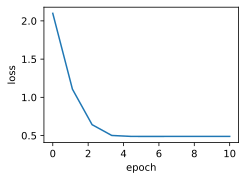

In [0]:
train_keras_ch7(keras.optimizers.RMSprop(learning_rate=0.01,rho=0.8),features,labels,batch_size=50,num_epochs=10)

###7.6.4. 小结
* RMSProp算法和AdaGrad算法的不同在于，RMSProp算法使用了小批量随机梯度按元素平方的指数加权移动平均来调整学习率。